## Wonderwheel
  > [Link to post](http://ameroyer.github.io/visualization,/data,/html,/css,/python/2017/12/02/wonderwheel.html)
  
  ![preview](preview.png)

This is a small project to visualize images as color histograms. More specifically:

  * I first map the input image to the HSV (Hue Saturation Value) domain;
  * then I exclude visually white and black pixels (i.e., those whose value is not in a certain given range), for which I build a separate histogram.  
  * The remaining pixels will be used to compute the hue histograms. Each hue is additionally weighted by its saturation (low saturation values get smaller weights) and its "originality" (how far it is from the average hue in the image). The color of the bar is additionally affected by the average saturation and value for this specific hue in the image.

In [1]:
import os
import colorsys
import numpy as np
from scipy import ndimage
from scipy.misc import imread, imresize
from matplotlib import colors

In [49]:
def create_equalizer(image, 
                     num_bins=100, 
                     originality_weight=0.1, 
                     sat_weight=2, 
                     black_value_threshold=0.2, 
                     white_value_threshold=0.9):
    # RGB -> HSV
    hue, sat, val = np.split(colors.rgb_to_hsv(image / 255.), 3, axis=-1)
    
    # isolate black and white tones by value
    white_values = np.where(val > white_value_threshold)
    black_values = np.where(val < black_value_threshold)
    
    # Black tones histograms
    hue_bins = np.linspace(0.0, 1.0, num_bins + 1, endpoint=True)
    mask = np.zeros_like(hue)
    mask[black_values] = sat[black_values]**sat_weight
    black_hist, _ = np.histogram(hue, bins=hue_bins, weights=mask)
    black_hist[np.isnan(black_hist)] = 0.
    
    # White tones histograms
    mask = np.zeros_like(hue)
    mask[white_values] = sat[white_values]**sat_weight
    white_hist, _ = np.histogram(hue, bins=hue_bins, weights=mask)
    white_hist[np.isnan(white_hist)] = 0.
    
    # Build the weighted hue histogram
    hue[white_values] = -1
    hue[black_values] = -1
    sat -= np.amin(sat)
    sat /= np.amax(sat)
    weights = 1. + originality_weight * np.abs(hue - np.mean(hue[hue >= 0])) * sat**sat_weight
    hue_hist, _ = np.histogram(hue, bins=hue_bins, weights=weights)
    hue_hist[np.isnan(hue_hist)] = 0.
    
    # Store bin heights data
    data = {'hues': hue_hist / np.amax(hue_hist),
            'white': white_hist / np.amax(white_hist) if np.sum(white_hist) > 0. else white_hist,
            'black': black_hist / np.amax(black_hist) if np.sum(black_hist) > 0. else black_hist}
    hue_bins = (hue_bins[1:] + hue_bins[:-1]) / 2
    data['centers'] = hue_bins
    bins_offset = 1.0 / num_bins
    
    # Compute bar colors based on average saturation and value
    data['colors'] = []
    for i, bin_center in enumerate(hue_bins):
        index = np.where((hue > bin_center  - bins_offset) & (hue < bin_center + bins_offset))
        color = colorsys.hsv_to_rgb(bin_center, 1., 1.)
        if index[0].shape[0] > 0: 
            color = colorsys.hsv_to_rgb(bin_center, np.mean(sat[index]), np.mean(val[index]))
        data['colors'].append([int(x * 255) for x in color])
        
    return data

This results in the following kind of histogram:

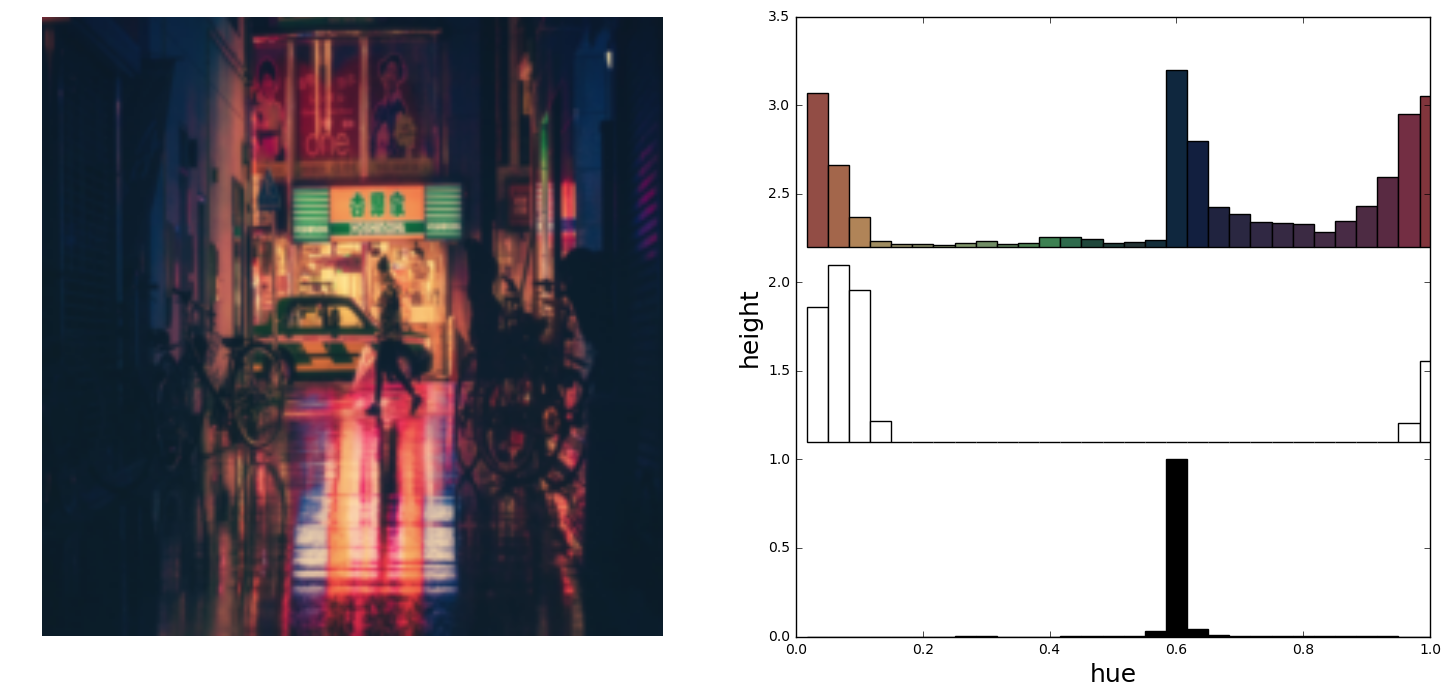

In [50]:
from matplotlib import pyplot as plt
image = imread('images/image2.jpeg')
image = imresize(image, (200, 200))

num_bins = 30
data = create_equalizer(image, num_bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.imshow(image)
ax1.set_axis_off()

hue_bins = np.linspace(0.0, 1.0, num_bins + 1, endpoint=True)
hue_bins = (hue_bins[1:] + hue_bins[:-1]) / 2
ax2.bar(hue_bins, data['black'], width=1. / num_bins, bottom=0., color='k' )
ax2.bar(hue_bins, data['white'], width=1. / num_bins, bottom=1.1, color='w', edgecolor='k')
bars = ax2.bar(hue_bins, data['hues'], width=1. / num_bins, bottom=2.2)
for bar, c in zip(bars, data['colors']):
    bar.set_facecolor([x / 255. for x in c])
ax2.set_xlim([0., 1.])
ax2.set_xlabel('hue', fontsize=18)
ax2.set_ylabel('height', fontsize=18)
plt.show()

Finally, I added a small animation component for the visualization. I generate a color histogram for a given image  at different stage of bluriness (Gaussian filter with decreasing variance); the result is animated using simple html and css3 transitions.

In [51]:
def write_to_html(image_path, 
                  resize=400, 
                  num_bins=40, 
                  num_resolutions=10, 
                  duration=2, 
                  base_name='bar',
                  output_name='demo'):
    # Collect data
    image = imread(image_path)
    if resize is not None:
        w, h, _ = image.shape
        ratio = resize / max(w, h)
        image = imresize(image, (int(ratio * image.shape[0]),
                                 int(ratio * image.shape[1])))
    data = {}
    resolutions = np.linspace(40., 0., num_resolutions, endpoint=True)
    for r in resolutions:
        aux = ndimage.gaussian_filter(image, sigma=r)
        aux = create_equalizer(aux, num_bins=num_bins)
        if 'centers' not in data:
            data = aux
            for key in ['hues', 'white', 'black']:
                data[key] = np.expand_dims(data[key], 0)
        else:
            for key in ['hues', 'white', 'black']:
                data[key] = np.concatenate([data[key], 
                                            np.expand_dims(aux[key], 0)],
                                           axis=0)
                
    # Add time points
    times = np.linspace(5, 75, num_resolutions, endpoint=True)
    times = np.append(times, 100)
    times = np.insert(times, 0, 0)
    for key in ['hues', 'white', 'black']:
        data[key] = np.concatenate([np.zeros((1, num_bins)), data[key], data[key][-1][None, :]], 0)
    
    image_width = 200
    image_border = 3
    min_bar_height = 0
    max_black_bar_height = 20
    max_white_bar_height = 25
    max_color_bar_height = 65
    max_height = max_black_bar_height + max_white_bar_height + max_color_bar_height
    center = max_height + image_width // 2 + 4 * image_border
    bar_width = 20
    
    data['hues'] *= max_color_bar_height
    data['black'] *= max_black_bar_height
    data['white'] *= max_white_bar_height
        
    css_template = """
    .frame {{
        position: absolute;
        top: 0;
        margin:0;
        }}

    .{base_name} {{
        position: relative;
        width: {bar_width}px;
        margin:0;
        float: left;
        }}
    """.format(base_name=base_name,
               bar_width=bar_width)


    # Define bar 
    # to set: name of id, left and top position, rgb color, rotation
    bar_template = """
    #{name} {{
        left: {pos_left}px;
        top: {pos_top}px;
        background-color: rgb({r}, {g}, {b});
        -webkit-animation: {name}_anim {duration}s ease-out infinite ; 
        animation: {name}_anim {duration}s ease-out infinite;
        -ms-transform: rotate({rot}deg); /* IE 9 */
        -webkit-transform: rotate({rot}deg); /* Safari */
        transform: rotate({rot}deg);
        -webkit-transform-origin: 50% 0%;
        -moz-transform-origin: 50% 0%;
        -o-transform-origin: 50% 0%;
        transform-origin: 50% 0%;
        border: {border_width}px solid {border_color};
        }}
    """
    
    # Define bar animation
    # to set: base name, rgb color
    def write_anim(name, heights, colors=None):
        assert len(times) == len(heights)
        template = ""
        start = 'from'
        if colors is None:
            for i in range(len(times)):
                template += "%d%% {height: %dpx;}\n" % (times[i], int(heights[i]))
        else:
            for i in range(len(times)):
                template += "%d%% {height: %dpx; background:rgb(%d, %d, %d)}\n" % (
                    times[i], int(heights[i]), colors[i][0], colors[i][1], colors[i][2])
        # template
        template =  """       
        @-webkit-keyframes
        {name}_anim {{
            {content}
        }}
        """.format(name=name, content=template)
        return template
    
    # Define central image
    img_template = '<img style="z-index: 1; border-radius: 50%; border: 0; top: {topleft}px; \
    left:{topleft}px; height: {size}px; width:{size}px; position:relative" src="{path}">'.format(
        topleft=center - image_width // 2, size=image_width, path=os.path.abspath(image_path))
    
    num_bars = len(data['centers'])
    norm_angle = data['centers'][0]
    
    with open('%s.css' % output_name, 'w') as f:
        f.write(css_template)
        for i in range(num_bars):
            
            angle = int((data['centers'][i] - norm_angle) * 360)
            offset_top = np.sin((angle + 90.) / 360. * 2 * np.pi)
            offset_left = np.cos((angle + 90.)/ 360. * 2 * np.pi)
            offset_length = image_width // 2 + image_border * 2
            
            # Black bars
            name = "%s%d_black" % (base_name, i)
            border_color = 'white'
            if sum(np.round(data['black'][:, i])) > 0.:
                f.write(write_anim(name, data['black'][:, i]))
                border_color = 'black'
            f.write(bar_template.format(
                    name=name, 
                    duration=duration,
                    pos_top=center + int(offset_top * offset_length),
                    pos_left=center + int(offset_left * offset_length) - bar_width // 2,
                    rot=angle, 
                    r=0, g=0, b=0,
                    border_width=1,
                    border_color=border_color))
            
            # White bars
            offset_length += max_black_bar_height + image_border
            name = "%s%d_white" % (base_name, i)
            border_color = 'white'
            if sum(np.round(data['white'][:, i])) > 0.:
                f.write(write_anim(name, data['white'][:, i]))
                border_color = "#aaa"
            f.write(bar_template.format(
                    name=name, 
                    duration=duration,
                    pos_top=center + int(offset_top * offset_length),
                    pos_left=center + int(offset_left * offset_length) - bar_width - bar_width // 2,
                    rot=angle, 
                    r=255, g=255, b=255, 
                    border_width=1,
                    border_color=border_color))
            
            # Color bars
            offset_length += max_white_bar_height + image_border
            name = "%s%d_color" % (base_name, i)
            border_color = 'white'
            if sum(np.round(data['hues'][:, i])) > 0.:
                f.write(write_anim(name, data['hues'][:, i], 
                                   colors=[data['colors'][i] for _ in range(len(times))]))
                border_color = "rgb(%s, %s, %s)" % (data['colors'][i][0], data['colors'][i][1], data['colors'][i][2])
            f.write(bar_template.format(
                    name=name, 
                    duration=duration,
                    pos_top=center + int(offset_top * offset_length),
                    pos_left=center + int(offset_left * offset_length) - 2 * bar_width - bar_width // 2,
                    rot=angle, 
                    r=data['colors'][i][0],
                    g=data['colors'][i][1],
                    b=data['colors'][i][2],
                    border_width=1,
                    border_color=border_color))

    with open('%s.html' % output_name, 'w') as f:
        f.write("""<!DOCTYPE html>
        <html>
            <head>
                <link rel="stylesheet" type="text/css" href="{css}">
            </head>

            <body>
                <div style="width:{total_width}px; position:absolute; top:0; left:50%; margin-left:-{half_width}px">
                    {main_image}
                    {bar_divs}
                </div>
            </body> 
        </html>
        """.format(css=os.path.abspath('%s.css' % output_name),
                   total_width=2 * center,
                   half_width=center,
                   main_image=img_template,
                   bar_divs='\n'.join("""
                       <div class ="frame">
                           <div class="{base_name}" id="{base_name}{index}_black"></div>
                           <div class="{base_name}" id="{base_name}{index}_white"></div>
                           <div class="{base_name}" id="{base_name}{index}_color"></div>
                       </div>""".format(base_name=base_name, index=i) for i in range(num_bars)))
                )
        
write_to_html('images/image3.jpeg' % n, output_name='html/image3' % n, base_name='bar', duration=3)

<style>
.div0 {
    background-color: blue;
    width: auto;
    height: auto;
    margin-left: 200px;
}

    .div1 {  
        position: absolute;
        width: 20px;
        height: 20px;
        background-color: blue;
        margin:auto;
        vertical-align: middle;
        /*position: relative;*/
        bottom: 200px;
        float: left;
        -webkit-animation: myfirst 2s infinite ; /* Chrome, Safari, Opera */
        animation: myfirst 2s infinite;
        -webkit-transition-timing-function: ease-in-out; /* Safari and Chrome */
        transition-timing-function: ease-in-out;
    }


/* Chrome, Safari, Opera */
@-webkit-keyframes 

myfirst {
    from, 15%  {background:red; height:120px}
    26%, 42%  {background:red; height:210px} 
    42%, 75%  {background:red; height:190px}
    75%, 100% {background:red; height:120px}
    }
</style>